# Project description

Beta Bank customers are leaving: little by little, chipping away every month. The bankers figured out it’s cheaper to save the existing customers rather than to attract new ones.

We need to predict whether a customer will leave the bank soon. You have the data on clients’ past behavior and termination of contracts with the bank.

Build a model with the maximum possible F1 score. To pass the project, you need an F1 score of at least 0.59. Check the F1 for the test set.

Additionally, measure the AUC-ROC metric and compare it with the F1

## Data description

**Features**

- `RowNumber` — data string index
- `CustomerId` — unique customer identifier
- `Surname` — surname
- `CreditScore` — credit score
- `Geography` — country of residence
- `Gender` — gender
- `Age` — age
- `Tenure` — period of maturation for a customer’s fixed deposit (years)
- `Balance` — account balance
- `NumOfProducts` — number of banking products used by the customer
- `HasCrCard` — customer has a credit card
- `IsActiveMember` — customer’s activeness
- `EstimatedSalary` — estimated salary

**Target**

- `Exited` — сustomer has left

# Project Implementation

## Data examination and preparation 

### Importing libraries and reading the data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import plotly.express as px
#import plotly.offline as pyo
import plotly.io as pio
import warnings
import time
import random
#from google.colab import files
import io

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.utils import shuffle

from sklearn.preprocessing import OrdinalEncoder 

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

pio.renderers.default = "svg"
#pyo.init_notebook_mode()
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:

#uploaded = files.upload()
#data = pd.read_csv(io.BytesIO(uploaded['Churn.csv']))

try:
    data = pd.read_csv('datasets/Churn.csv')
except:
    data = pd.read_csv('/datasets/Churn.csv')
    
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


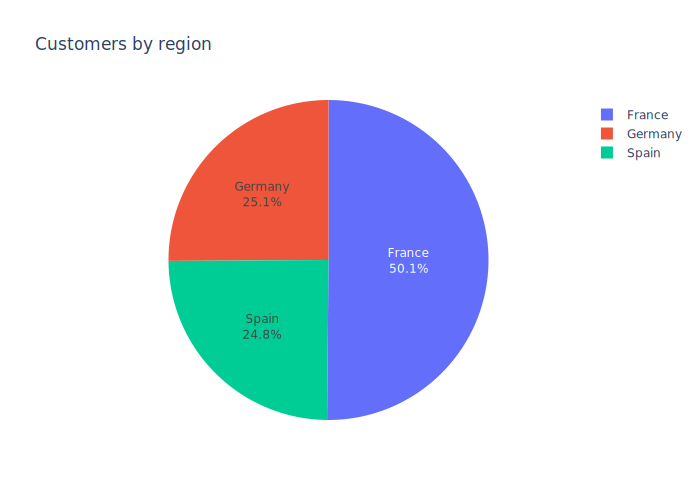

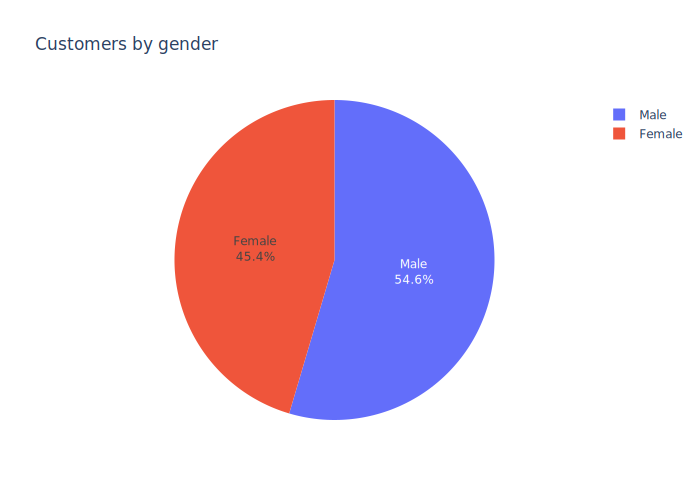

In [3]:
fig = px.pie(data, names='Geography', values='CustomerId', title='Customers by region')
fig.update_traces(text = data['Geography'])
fig.show()
#fig.show(renderer="colab")

fig = px.pie(data, names='Gender', values='CustomerId', title='Customers by gender')
fig.update_traces(text = data['Gender'])
fig.show()
#fig.show(renderer="colab")

### Dropping some columns and changing the dtypes

In [4]:
# Deleting the unnecessary column "RowNumber" 
data = data.drop('RowNumber', axis=1)

# Deleting the unnecessary columns which are not necessary for the ML model 
data = data.drop(['CustomerId', 'Surname'], axis=1)

# Correcting the columns' names
data.columns = ['credit_score', 'geography', 'gender', 'age', 'tenure', 'balance',
                'num_of_products', 'has_cr_card', 'is_active_member', 'estimated_salary', 'exited']

In [5]:
data.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   geography         10000 non-null  object 
 2   gender            10000 non-null  object 
 3   age               10000 non-null  int64  
 4   tenure            9091 non-null   float64
 5   balance           10000 non-null  float64
 6   num_of_products   10000 non-null  int64  
 7   has_cr_card       10000 non-null  int64  
 8   is_active_member  10000 non-null  int64  
 9   estimated_salary  10000 non-null  float64
 10  exited            10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


In [7]:
int8_columns = ['age', 'num_of_products', 'has_cr_card', 'is_active_member', 'exited']
int_columns = ['balance', 'estimated_salary']

# Converting int64 columns to int8 columns to save memory and decrease processing time
data[int8_columns] = data[int8_columns].astype('int8')
# Some columns' values are float, but considering the values, they can be just converted to int
data[int_columns] = data[int_columns].astype('int')

data.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2.0,0,1,1,1,101348,1
1,608,Spain,Female,41,1.0,83807,1,0,1,112542,0
2,502,France,Female,42,8.0,159660,3,1,0,113931,1
3,699,France,Female,39,1.0,0,2,0,0,93826,0
4,850,Spain,Female,43,2.0,125510,1,1,1,79084,0


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   geography         10000 non-null  object 
 2   gender            10000 non-null  object 
 3   age               10000 non-null  int8   
 4   tenure            9091 non-null   float64
 5   balance           10000 non-null  int32  
 6   num_of_products   10000 non-null  int8   
 7   has_cr_card       10000 non-null  int8   
 8   is_active_member  10000 non-null  int8   
 9   estimated_salary  10000 non-null  int32  
 10  exited            10000 non-null  int8   
dtypes: float64(1), int32(2), int64(1), int8(5), object(2)
memory usage: 439.6+ KB


### Handling the 'tenure' column missing values

In [9]:
# Looking for the unfilled data
data.isna().sum()

credit_score          0
geography             0
gender                0
age                   0
tenure              909
balance               0
num_of_products       0
has_cr_card           0
is_active_member      0
estimated_salary      0
exited                0
dtype: int64

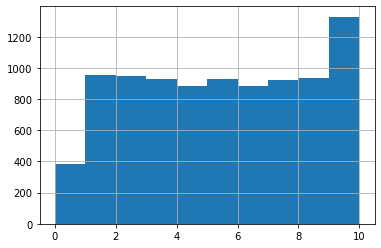

In [10]:
# 'tenure' column histogram before filling the missing data
data.tenure.hist()
plt.show()

In [11]:
# Let's fill the missed values in 'tenure' column with random integers from 1 to 9, as the most frequent ones
def randfill(row):
    value = row['tenure']
    if np.isnan(value):
        return random.randint(1, 10)
    else:
        return value
    
data['tenure'] = data.apply(randfill, axis=1)

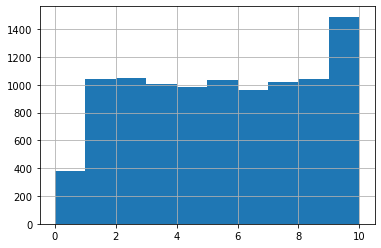

In [12]:
# 'tenure' column histogram after filling the missing data
data.tenure.hist()
plt.show()

In [13]:
# Looking for the unfilled data
data.isna().sum()

credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

In [14]:
# Looking for the duplicates
data.duplicated().sum()

0

In [15]:
# Looking for multucollinearity 
data.corr().round(2).style.background_gradient()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
credit_score,1.000000,-0.000000,-0.000000,0.010000,0.010000,-0.010000,0.030000,-0.000000,-0.030000
age,-0.000000,1.000000,-0.020000,0.030000,-0.030000,-0.010000,0.090000,-0.010000,0.290000
tenure,-0.000000,-0.020000,1.000000,-0.010000,0.010000,0.030000,-0.030000,0.010000,-0.020000
balance,0.010000,0.030000,-0.010000,1.000000,-0.300000,-0.010000,-0.010000,0.010000,0.120000
num_of_products,0.010000,-0.030000,0.010000,-0.300000,1.000000,0.000000,0.010000,0.010000,-0.050000
has_cr_card,-0.010000,-0.010000,0.030000,-0.010000,0.000000,1.000000,-0.010000,-0.010000,-0.010000
is_active_member,0.030000,0.090000,-0.030000,-0.010000,0.010000,-0.010000,1.000000,-0.010000,-0.160000
estimated_salary,-0.000000,-0.010000,0.010000,0.010000,0.010000,-0.010000,-0.010000,1.000000,0.010000
exited,-0.030000,0.290000,-0.020000,0.120000,-0.050000,-0.010000,-0.160000,0.010000,1.000000


In [16]:
data.describe()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.042100,76485.571500,1.530200,0.70550,0.515100,100089.748400,0.203700
std,96.653299,10.487806,2.891948,62397.185107,0.581654,0.45584,0.499797,57510.491042,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.000000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51001.750000,0.000000
50%,652.000000,37.000000,5.000000,97198.000000,1.000000,1.00000,1.000000,100193.500000,0.000000
75%,718.000000,44.000000,8.000000,127643.750000,2.000000,1.00000,1.000000,149387.750000,0.000000
max,850.000000,92.000000,10.000000,250898.000000,4.000000,1.00000,1.000000,199992.000000,1.000000


In [17]:
data.describe(include=['object', 'bool'])

,geography,gender
count,10000,10000
unique,3,2
top,France,Male
freq,5014,5457


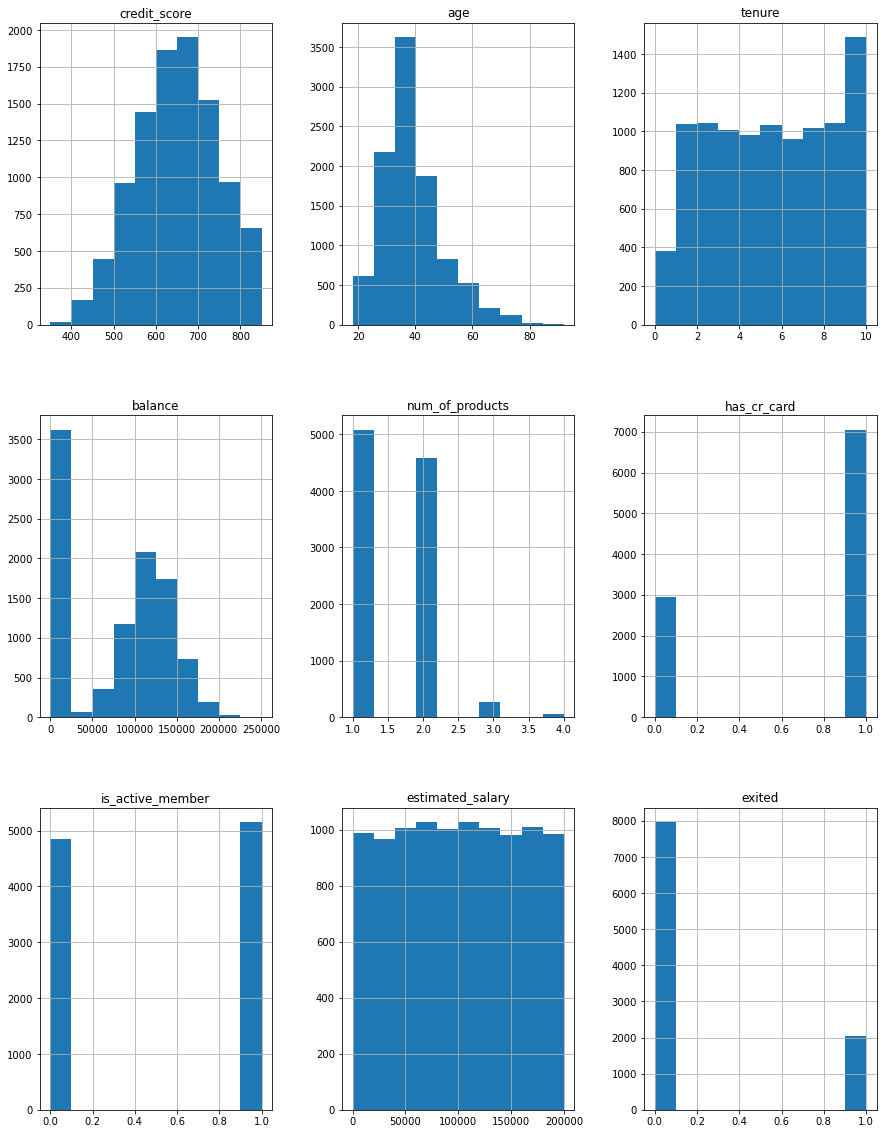

In [18]:
data.hist(figsize=(15, 20))
plt.show()

### Conclusion

The data was examined and prepared for the ML process:

 - Unnecessary columns have been deleted.
 - Columns' names have been corrected.
 - Data types of the selected columns have been changed. This has resulted in ~2 times memory consumption reduction.  
 - No multicollinear values have been found.
 - There is a slight correlation between columns `age` and `exited`
 - Some clients do not have any money on their accounts.
 - There are 909 missing values in "tenure" column. We have filled them with most frequent random integers.
 - More than 50% of the clients are from France.
 - There are slightly more male clients than female clients.

## Trining models with the raw data

### Regression predictions

#### Divide the sample into training, validation and test

In [19]:
features = data.drop('exited', axis=1)
target= data['exited']

features_train, features_rem, target_train, target_rem = train_test_split(features, target, test_size=0.4, random_state=42)
features_train.shape, features_rem.shape

((6000, 10), (4000, 10))

In [20]:
features_valid, features_test, target_valid, target_test = train_test_split(features_rem, target_rem, test_size=0.5, random_state=42)
features_valid.shape, features_test.shape

((2000, 10), (2000, 10))

#### Logistic Regression predictions and OHE

In [21]:
features_train_ohe = pd.get_dummies(features_train, drop_first=True)
features_valid_ohe = pd.get_dummies(features_valid, drop_first=True)
features_test_ohe = pd.get_dummies(features_test, drop_first=True)

model = LogisticRegression()
model.fit(features_train_ohe, target_train)
predictions_valid = model.predict(features_valid_ohe)
print(f'F1 score on the validation sample = {f1_score(target_valid, predictions_valid)}')
predictions_test = model.predict(features_test_ohe)
print(f'F1 score on the test sample = {f1_score(target_valid, predictions_test)}')


F1 score on the validation sample = 0.11160714285714286
F1 score on the test sample = 0.07947019867549669


AUC-ROC score:0.6484015594541911


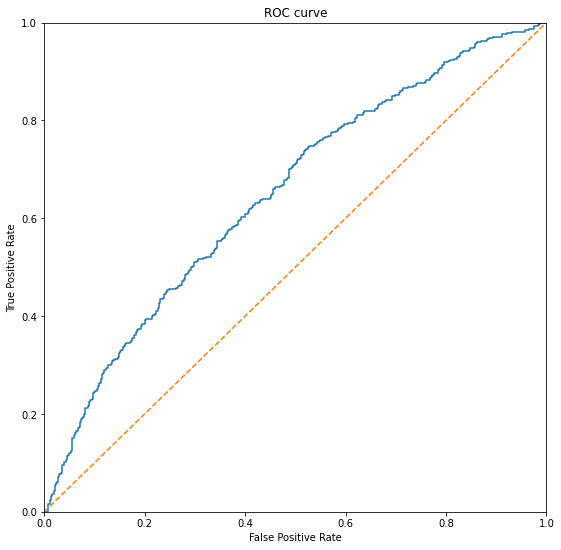

In [22]:
probabilities_valid = model.predict_proba(features_valid_ohe)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid) 

print(f'AUC-ROC score:{auc_roc}')

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure(figsize=(9,9))

plt.plot(fpr, tpr)

# ROC curve for random model (looks like a straight line)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

plt.show()

### Tree-based predictions

#### Label Encoding WITHOUT imbalance

In [23]:
encoder = OrdinalEncoder()
encoder.fit(features)

features_train_le = pd.DataFrame(encoder.transform(features_train), columns=features_train.columns)
features_valid_le = pd.DataFrame(encoder.transform(features_valid), columns=features_valid.columns)
features_test_le = pd.DataFrame(encoder.transform(features_test), columns=features_test.columns)

#### Decision Tree Classifier


F1 score of the best model on validation features = 0.522
F1 score of the best model on test features = 0.555
depth of the best model = 8


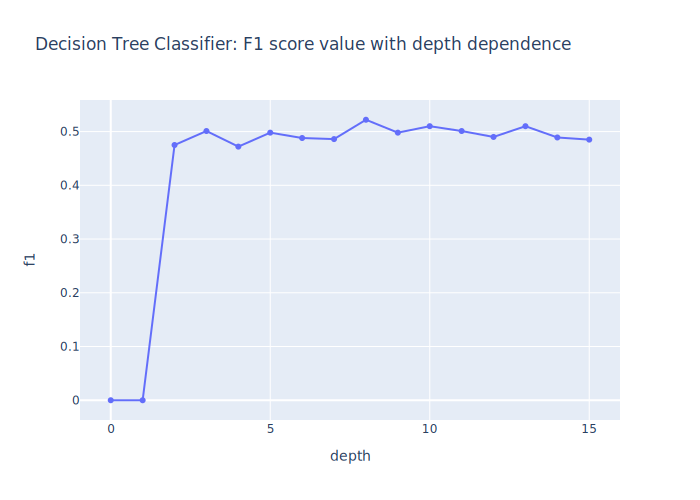

Wall time: 522 ms


In [24]:
%%time
result_df = pd.DataFrame({'depth': [0], 'f1': [0]})

best_model= None
best_result = 0
best_depth = 0
best_f1 = 0

for depth in range(1, 16):
    model = DecisionTreeClassifier(random_state=42, max_depth=depth)
    model.fit(features_train_le, target_train)
    predictions = model.predict(features_valid_le)
    result = f1_score(target_valid, predictions)
    result_df.loc[depth] = (depth, round(result, 3))
    if result > best_result:
        best_model = model
        best_depth = depth
        best_f1 = result
        best_result = result

best_f1_test = f1_score(best_model.predict(features_test_le), target_test)
print('')
print(f'F1 score of the best model on validation features = {round(best_f1, 3)}')
print(f'F1 score of the best model on test features = {round(best_f1_test, 3)}')
print(f'depth of the best model = {best_depth}')

fig = px.line(result_df, x='depth', y='f1', markers=True,
              title='Decision Tree Classifier: F1 score value with depth dependence')
fig.show()
#fig.show(renderer="colab")

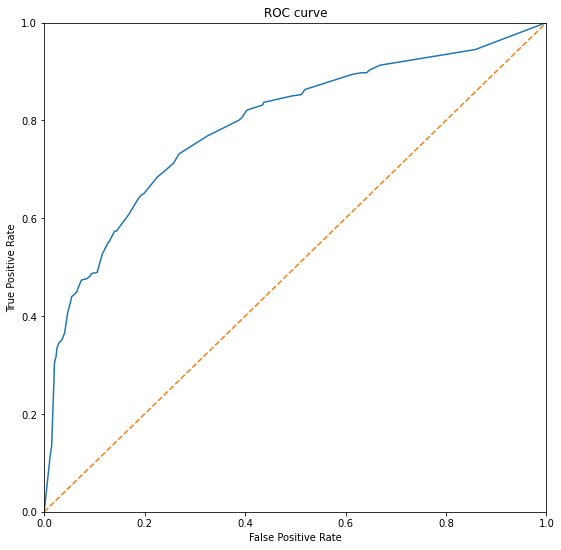

In [25]:
probabilities_valid = best_model.predict_proba(features_valid_le)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure(figsize=(9,9))

plt.plot(fpr, tpr)

# ROC curve for random model (looks like a straight line)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

plt.show()

#### Random Forest Classifier

In [26]:
%%time

best_model= None
best_result = 0
best_n_est = 0
best_depth = 0

result_df = pd.DataFrame({'est': [0], 'f1': [0]})
for est in range(1, 21):
    for depth in range(1, 21):
        model = RandomForestClassifier(random_state=42, n_estimators=est, max_depth=depth)
        model.fit(features_train_le, target_train)
        predictions = model.predict(features_valid_le)
        result = f1_score(target_valid, predictions)
        result_df.loc[depth] = (depth, round(result, 3))
    if result > best_result:
        best_result = result
        best_n_est = est
        best_model = model
        best_depth = depth
    #print(f'n_est = {est}, depth = {depth}, f1 score = {round(result, 2)}, best f1 score = {round(best_result, 2)}')

best_f1_test = f1_score(best_model.predict(features_test_le), target_test)
print('')
print(f'F1 score of the best model on validation features = {round(best_result, 3)}')
print(f'F1 score of the best model on test features = {round(best_f1_test, 3)}')
print(f'n_estimators of the best model = {best_n_est}')
print(f'depth of the best model = {best_depth}')

  


F1 score of the best model on validation features = 0.553
F1 score of the best model on test features = 0.59
n_estimators of the best model = 19
depth of the best model = 20
Wall time: 29.6 s


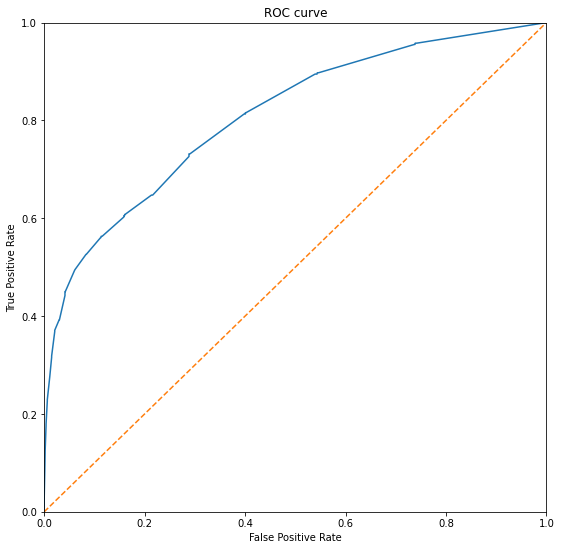

In [27]:
probabilities_valid = best_model.predict_proba(features_valid_le)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure(figsize=(9,9))

plt.plot(fpr, tpr)

# ROC curve for random model (looks like a straight line)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

plt.show()

### Conclusion

Training logistic regression with the raw data is not a good idea. The model's F1 score was ~0.07 which is very low. ROC curve has shown that the model works just a slightly better than a random model. On the other hand, tree-based models have shown decent results with F1 scores > 0.55 which is very close to what was asked in the task. Their ROC curves have also shown that they give pretty good predictions.

## Models preparation considering the classification imbalance

In [28]:
# amount of positive and negative values in the 'exited' column
data.exited.value_counts()

0    7963
1    2037
Name: exited, dtype: int64

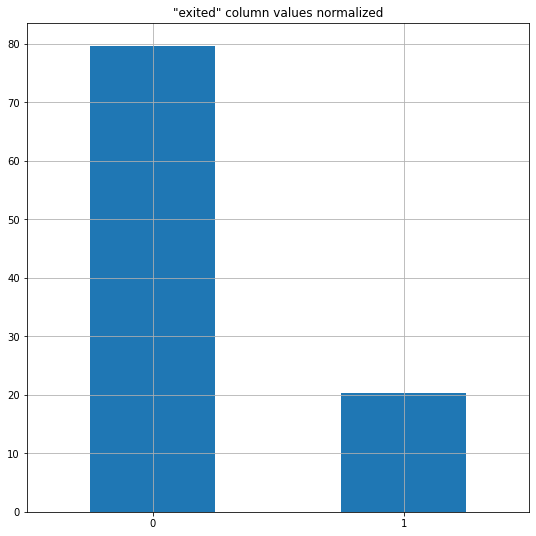

In [29]:
#  relative percentage of the values in the 'exited' column
data.exited.value_counts(normalize=True).mul(100).plot(kind='bar', title='"exited" column values normalized', rot=0, grid=True, figsize=(9,9))
plt.show()

We can see, that ~20% of our dataset is comprised from the customers who left the bank. The dataset is imbalanced. We can try both downsampling and upsampling to correct this issue.



### Class weight adjustment

#### Logistic Regression

In [30]:
model = LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced')
model.fit(features_train_ohe, target_train)
predictions_valid = model.predict(features_valid_ohe)
print(f'F1 score on the validation sample = {f1_score(target_valid, predictions_valid)}')
predictions_test = model.predict(features_test_ohe)
print(f'F1 score on the test sample = {f1_score(target_valid, predictions_test)}')

F1 score on the validation sample = 0.3973399833748961
F1 score on the test sample = 0.24757281553398056


#### Decision Tree


F1 score of the best model on validation features = 0.522
F1 score of the best model on test features = 0.573
depth of the best model = 5


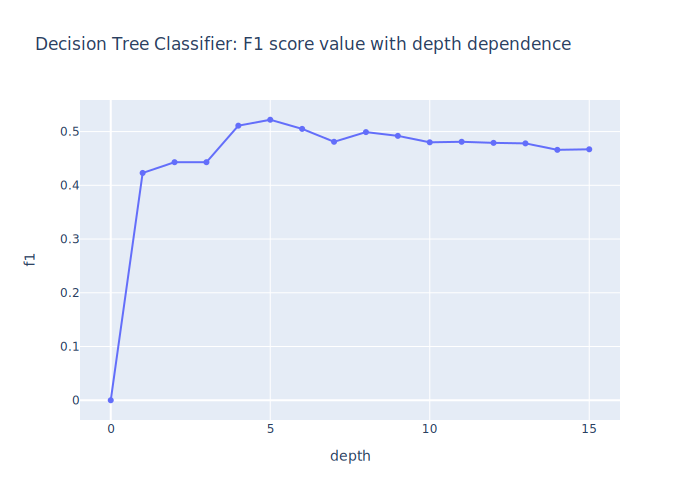

Wall time: 547 ms


In [31]:
%%time
result_df = pd.DataFrame({'depth': [0], 'f1': [0]})

best_model= None
best_result = 0
best_depth = 0
best_f1 = 0

for depth in range(1, 16):
    model = DecisionTreeClassifier(random_state=42, max_depth=depth, class_weight='balanced')
    model.fit(features_train_le, target_train)
    predictions = model.predict(features_valid_le)
    result = f1_score(target_valid, predictions)
    result_df.loc[depth] = (depth, round(result, 3))
    if result > best_result:
        best_model = model
        best_depth = depth
        best_f1 = result
        best_result = result

best_f1_test = f1_score(best_model.predict(features_test_le), target_test)
print('')
print(f'F1 score of the best model on validation features = {round(best_f1, 3)}')
print(f'F1 score of the best model on test features = {round(best_f1_test, 3)}')
print(f'depth of the best model = {best_depth}')

fig = px.line(result_df, x='depth', y='f1', markers=True,
              title='Decision Tree Classifier: F1 score value with depth dependence')
fig.show()
#fig.show(renderer="colab")

#### Random Forest Classifier

In [32]:
%%time

best_model= None
best_result = 0
best_n_est = 0
best_depth = 0

result_df = pd.DataFrame({'est': [0], 'f1': [0]})
for est in range(1, 21):
    for depth in range(1, 21):
        model = RandomForestClassifier(random_state=42, n_estimators=est, max_depth=depth, class_weight='balanced')
        model.fit(features_train_le, target_train)
        predictions = model.predict(features_valid_le)
        result = f1_score(target_valid, predictions)
        result_df.loc[depth] = (depth, round(result, 3))
    if result > best_result:
        best_result = result
        best_n_est = est
        best_model = model
        best_depth = depth
    #print(f'n_est = {est}, depth = {depth}, f1 score = {round(result, 2)}, best f1 score = {round(best_result, 2)}')

final_model = best_model

best_f1_test = f1_score(best_model.predict(features_test_le), target_test)
print('')
print(f'F1 score of the best model on validation features = {round(best_result, 3)}')
print(f'F1 score of the best model on test features = {round(best_f1_test, 3)}')
print(f'n_estimators of the best model = {best_n_est}')
print(f'depth of the best model = {best_depth}')


F1 score of the best model on validation features = 0.53
F1 score of the best model on test features = 0.564
n_estimators of the best model = 19
depth of the best model = 20
Wall time: 34 s


### Conclusion

Logistic regression with class weight adjustment have shown on the test sample the F1 score which is 4 times higher than without weight adjustment. The F1 score on the validation sample was 0.46 which is also pretty high. Additionally, class weight adjustment has also significantly increased the F1 scores of both tree-based models. The best modelf of the random forest classifier has shown F1 = 0.619, which is more than what was asked in the task.

### Positive data upsampling

In [33]:
def upsample(features, target, repeat):
  # Split the training sample into negative and positive observations
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    # Duplicate the positive observations several times
    # Create a new training sample based on the data obtained
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    # Shuffle the data: identical questions following one another will not help the training
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=42)

    return features_upsampled, target_upsampled
  
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

print(f'features_train.shape: {features_train.shape} target_train.shape: {target_train.shape}')
print('')
print(f'features_upsampled.shape: {features_upsampled.shape} target_upsampled.shape: {target_upsampled.shape}')

features_train.shape: (6000, 10) target_train.shape: (6000,)

features_upsampled.shape: (9681, 10) target_upsampled.shape: (9681,)


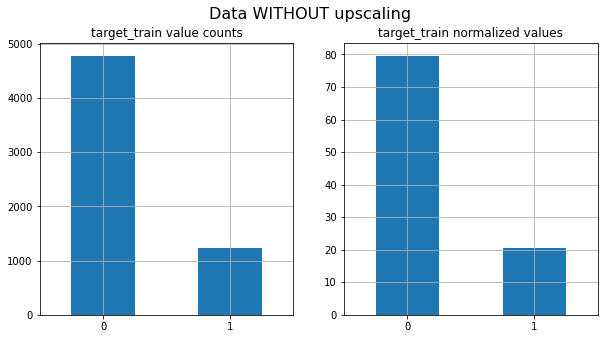

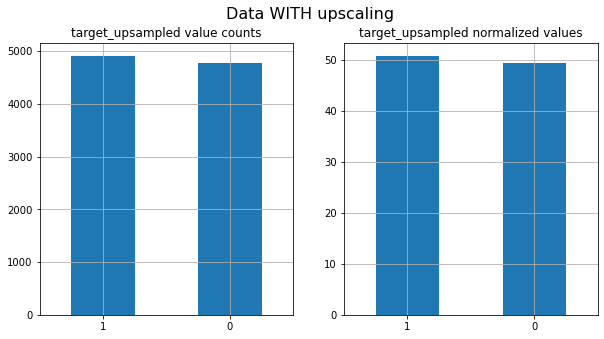

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
fig.suptitle('Data WITHOUT upscaling', fontsize=16)
target_train.value_counts().plot(ax=ax[0],kind='bar', rot=0, title='target_train value counts', grid=True)
target_train.value_counts(normalize=True).mul(100).round(3).plot(ax=ax[1], kind='bar', title='target_train normalized values', rot=0, grid=True)
fig.show()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
fig.suptitle('Data WITH upscaling', fontsize=16)
target_upsampled.value_counts().plot(ax=ax[0], kind='bar', title='target_upsampled value counts', rot=0, grid=True)
target_upsampled.value_counts(normalize=True).mul(100).round(3).plot(ax=ax[1],kind='bar', rot=0, title='target_upsampled normalized values', grid=True)
fig.show()

#### Regression predictions

##### Logistic Regression predictions and OHE with imbalancing


In [35]:
features_upsampled, target_upsampled = upsample(features_train_ohe, target_train, 4)

In [36]:
#model = LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced')
model = LogisticRegression(random_state=42)
#model.fit(features_train_ohe, target_train)
model.fit(features_upsampled, target_upsampled)
predictions_valid = model.predict(features_valid_ohe)
predictions_test = model.predict(features_test_ohe)
print(f'F1 score on the validation sample: {f1_score(target_valid, predictions_valid)}')
print(f'F1 score on the test sample: {f1_score(target_test, predictions_test)}')

F1 score on the validation sample: 0.39903846153846156
F1 score on the test sample: 0.4595808383233533


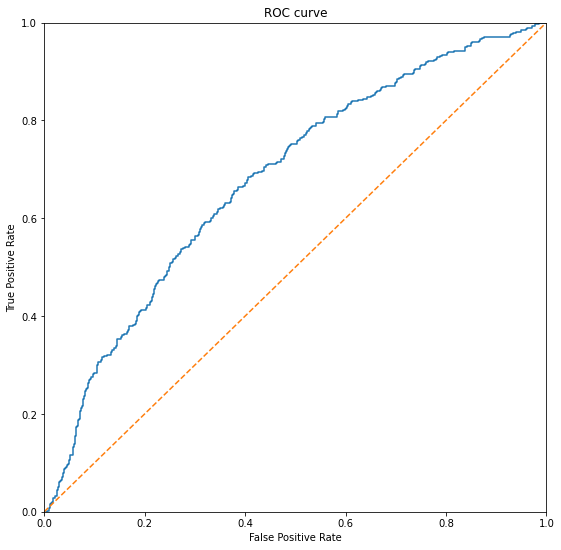

In [37]:
probabilities_valid = model.predict_proba(features_valid_ohe)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure(figsize=(9,9))

plt.plot(fpr, tpr)

# ROC curve for random model (looks like a straight line)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

plt.show()

#### Tree-based predictions

##### Label Encoding WITH imbalance

In [38]:
# upsampling train data
features_train_upsampled, target_train_upsampled = upsample(features_train, target_train, 4)

In [39]:
# making label encoding on the upsampled train data
features_train_upsampled_le = pd.DataFrame(encoder.transform(features_train_upsampled), columns=features_train_upsampled.columns)

In [40]:
features_train_upsampled_le.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary
0,121.0,2.0,1.0,18.0,1.0,0.0,0.0,0.0,1.0,6641.0
1,241.0,1.0,1.0,23.0,8.0,3720.0,3.0,1.0,0.0,4600.0
2,397.0,1.0,0.0,39.0,8.0,1148.0,0.0,1.0,1.0,8812.0
3,163.0,2.0,1.0,8.0,8.0,5213.0,0.0,1.0,1.0,8703.0
4,313.0,1.0,1.0,9.0,5.0,5093.0,0.0,1.0,0.0,3116.0


##### Decision Tree Classifier


F1 score of the best model on validation features = 0.511
F1 score of the best model on test features = 0.58
depth of the best model = 4


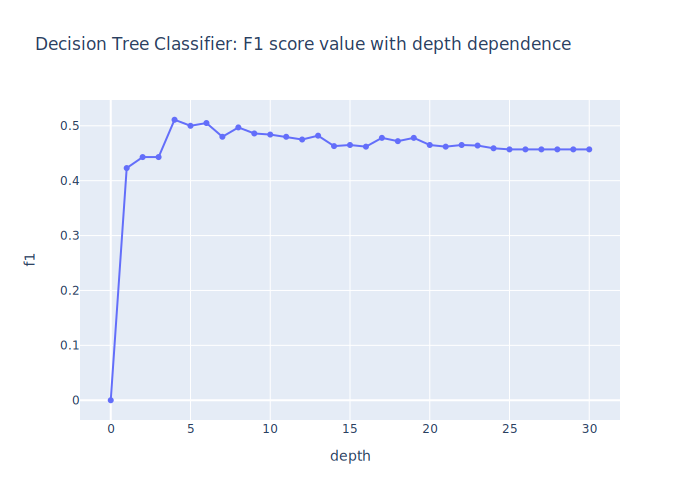

Wall time: 1.17 s


In [41]:
%%time
result_df = pd.DataFrame({'depth': [0], 'f1': [0]})

best_model= None
best_result = 0
best_depth = 0
best_f1 = 0

for depth in range(1, 31):
    model = DecisionTreeClassifier(random_state=42, max_depth=depth)
    model.fit(features_train_upsampled_le, target_train_upsampled)
    predictions = model.predict(features_valid_le)
    result = f1_score(target_valid, predictions)
    result_df.loc[depth] = (depth, round(result, 3))
    if result > best_result:
        best_model = model
        best_depth = depth
        best_f1 = result
        best_result = result

best_f1_test = f1_score(best_model.predict(features_test_le), target_test)
print('')
print(f'F1 score of the best model on validation features = {round(best_f1, 3)}')
print(f'F1 score of the best model on test features = {round(best_f1_test, 3)}')
print(f'depth of the best model = {best_depth}')

fig = px.line(result_df, x='depth', y='f1', markers=True,
              title='Decision Tree Classifier: F1 score value with depth dependence')
fig.show()
#fig.show(renderer="colab")

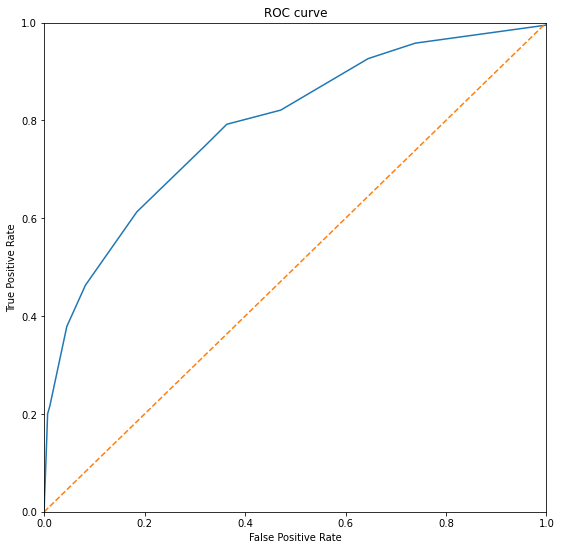

In [42]:
probabilities_valid = best_model.predict_proba(features_valid_le)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure(figsize=(9,9))

plt.plot(fpr, tpr)

# ROC curve for random model (looks like a straight line)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

plt.show()

##### Random Forest Classifier

In [43]:
%%time

best_model= None
best_result = 0
best_n_est = 0
best_depth = 0

result_df = pd.DataFrame({'est': [0], 'f1': [0]})
for est in range(1, 21):
    for depth in range(1, 21):
        model = RandomForestClassifier(random_state=42, n_estimators=est, max_depth=depth)
        model.fit(features_train_upsampled_le, target_train_upsampled)
        predictions = model.predict(features_valid_le)
        result = f1_score(target_valid, predictions)
        result_df.loc[depth] = (depth, round(result, 3))
    if result > best_result:
        best_result = result
        best_n_est = est
        best_model = model
        best_depth = depth
    #print(f'n_est = {est}, depth = {depth}, f1 score = {round(result, 2)}, best f1 score = {round(best_result, 2)}')

best_f1_test = f1_score(best_model.predict(features_test_le), target_test)
print('')
print(f'F1 score of the best model on validation features = {round(best_result, 3)}')
print(f'F1 score of the best model on test features = {round(best_f1_test, 3)}')
print(f'n_estimators of the best model = {best_n_est}')
print(f'depth of the best model = {best_depth}')


F1 score of the best model on validation features = 0.548
F1 score of the best model on test features = 0.592
n_estimators of the best model = 20
depth of the best model = 20
Wall time: 39 s


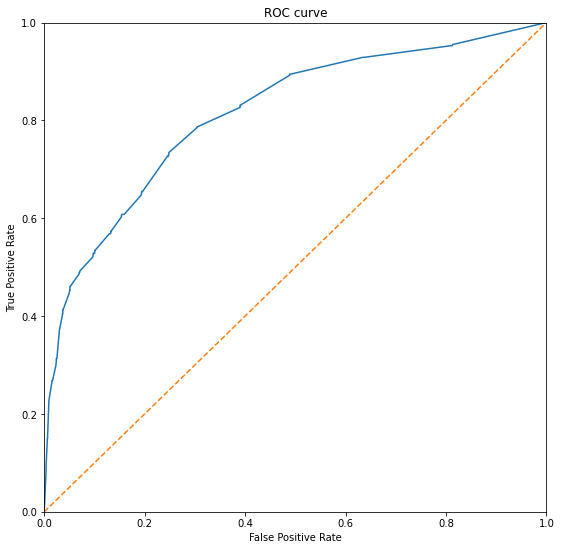

In [44]:
probabilities_valid = best_model.predict_proba(features_valid_le)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure(figsize=(9,9))

plt.plot(fpr, tpr)

# ROC curve for random model (looks like a straight line)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

plt.show()

### Conclusion

Positive data upsampling have greatly increased the F1 score of the Logistic Regression model, and the difference in the F1 score between validation and test samples is much lower than in the case of simple weight adjustment technique. Random Forest have shown the best quality in the test sample with the F1 = 0.606 which is higher than was asked in the task.



## Relative importance of the features

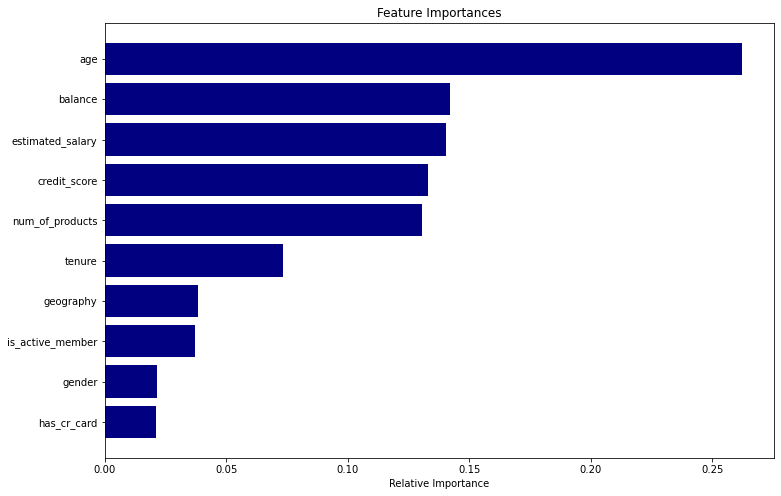

In [45]:
#plot a curve showing the relative importance of each feature on the model
features=features_train_le.columns.tolist()
importances=final_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='navy', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Final conclusion

In this project we have implemented supervised learning for several ML algorithms. Data upscaling has significantly increased the F1 score for the Logistic Regression. However, tree-based models work very good even with weight adjustment. The best result have been demonstrated by the Random Forest with class weight adjustment, the model has demonstrated F1 score = 0.622

Feature importances have shown that age, number of products, and balance are the most important factors in predicting the client churn.